In [1]:
import numpy as np
import math

In [2]:
import flatbuffers as fb
from tflite import * 

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# weird constants? ew
# should probably find nicer way to use these vals

HEIGHT = 1
WIDTH = 2

LEFT = 0
RIGHT = 1
TOP = 2
BOTTOM = 3

pad_to_str = {Padding.SAME : 'SAME',
              Padding.VALID : 'VALID'
             }

activation_to_str = {ActivationFunctionType.NONE : 'NONE',
                     ActivationFunctionType.RELU : 'RELU',
                     ActivationFunctionType.RELU6 : 'RELU6'
                    }

In [5]:
def get_padding(pad, 
                filter_shape, 
                in_shape, 
                stride_h=1, 
                stride_w=1, 
                dilate_h=1, 
                dilate_w=1
               ):
    
    padding = [0,0,0,0]

    if pad == Padding.SAME:
        dilated_width = (filter_shape[WIDTH] - 1) * dilate_w + 1
        dilated_height = (filter_shape[HEIGHT] - 1) * dilate_h + 1

        out_w = math.ceil(in_shape[WIDTH] / stride_w)
        out_h = math.ceil(in_shape[HEIGHT] / stride_h)

        padding[LEFT] = math.floor(dilated_width / 2)
        padding[RIGHT] = out_w * stride_w - (stride_w - 1) + math.floor(filter_shape[WIDTH] / 2) - in_shape[WIDTH]
        padding[TOP] = math.floor(dilated_height / 2)
        padding[BOTTOM] = out_h * stride_h - (stride_h - 1) + math.floor(filter_shape[HEIGHT] / 2) - in_shape[HEIGHT]                

    return padding
       

In [6]:
def get_final_shape(in_shape, 
                    filter_shape, 
                    pad=Padding.VALID, 
                    stride_h=1, 
                    stride_w=1, 
                    dilate_h=1, 
                    dilate_w=1
                   ):
    w = 0
    h = 0

    if pad == Padding.SAME:
        w = math.ceil(in_shape[WIDTH] / stride_w)
        h = math.ceil(in_shape[HEIGHT] / stride_h)
        
    elif pad == Padding.VALID:
        dilated_height = (filter_shape[HEIGHT] - 1) * dilate_h + 1
        dilated_width = (filter_shape[WIDTH] - 1) * dilate_w + 1
        
        w = math.ceil((in_shape[WIDTH] - dilated_width + 1) / stride_w)
        h = math.ceil((in_shape[HEIGHT] - dilated_height + 1) / stride_h)

    return (h, w)


## Im2col

In [7]:
def im2col(input_data,
           filter_shape, 
           final_shape,
           stride_h=1, 
           stride_w=1,
           dilate_h=1, 
           dilate_w=1,
           pad=[0,0,0,0], # left right top bottom
          ):
    
    filter_h = (filter_shape[HEIGHT]-1) * dilate_h + 1
    filter_w = (filter_shape[WIDTH]-1) * dilate_w + 1
    channels = input_data.shape[-1]
    

    def get_pixel(row, col):
        if 0 <= row < input_data.shape[HEIGHT] and 0 <= col < input_data.shape[WIDTH]:
            return input_data[0, row, col, :]
        return np.zeros(channels)

    pixels_per_col = filter_shape[1] * filter_shape[2] * filter_shape[3]
    num_cols = np.prod(final_shape)
    
    cols = np.empty((pixels_per_col, num_cols))
    print('im2col shape:', cols.shape)
    
    
    # loop over image
    col_idx = 0
    for r in range(-pad[TOP], input_data.shape[HEIGHT] - filter_h + 1 + pad[BOTTOM], stride_h):
        for c in range(-pad[LEFT], input_data.shape[WIDTH] - filter_w + 1 + pad[RIGHT], stride_w):
            
            # loop over kernel
            row_idx = 0
            for row in range(r, r + filter_h, dilate_h):
                for col in range(c, c + filter_w, dilate_w):
                    cols[row_idx:row_idx + channels, col_idx] = get_pixel(row, col)
                    row_idx += channels
                    
            col_idx += 1
         
    return cols

## Activations

In [8]:
def activation(tensor, activate):
    
    print('activation:', activation_to_str[activate])
    
    if activate == ActivationFunctionType.NONE:
        return tensor
    elif activate == ActivationFunctionType.RELU:
        return relu(tensor)
    elif activate == ActivationFunctionType.RELU6:
        return relu6(tensor)
    else:
        raise NotImplementedError()

def relu(tensor):
    return np.maximum(0, tensor)

def relu6(tensor):
    return np.minimum(np.maximum(tensor, 0), 6)


# CONV2D

In [9]:
def conv2d(input_data, 
           filter_weights,
           bias_weights=None,
           stride_h=1, 
           stride_w=1, 
           dilate_h=1, 
           dilate_w=1, 
           pad=Padding.VALID, 
           activate=ActivationFunctionType.NONE
          ):
    
    padding = get_padding(pad, filter_weights.shape, input_data.shape, stride_h, stride_w, dilate_h, dilate_w)

    # display stuff and make sure it's correct
    print('********DOING CONV2D********')
    print('input shape:', input_data.shape)
    print('filter shape:', filter_weights.shape)
    print('stride_h:', stride_h)
    print('stride_w:', stride_w)
    print('dilate_h_factor:', dilate_h)
    print('dilate_w_factor:', dilate_w)
    print('padding:', pad_to_str[pad], padding)

    shape = get_final_shape(input_data.shape, filter_weights.shape, pad, stride_h=stride_h, stride_w=stride_w)

    my_im2col = im2col(input_data, 
                       filter_weights.shape, 
                       shape,
                       stride_h=stride_h,
                       stride_w=stride_w, 
                       dilate_h=dilate_h, 
                       dilate_w=dilate_w, 
                       pad=padding,
                      )

    out = (filter_weights.reshape((filter_weights.shape[0], -1)) @ my_im2col).transpose()
    
    out = out.reshape((input_data.shape[0], shape[0], shape[1], filter_weights.shape[0]))

    print('output shape:', out.shape)
    if bias_weights is not None:
        out = np.add(out, bias_weights)
    
    return activation(out, activate)
               

# DEPTHWISE CONV

In [10]:
def depthwise_conv(input_data, 
                   filter_weights, 
                   bias_weights=None, 
                   stride_h=1, 
                   stride_w=1, 
                   dilate_h=1, 
                   dilate_w=1, 
                   pad=Padding.VALID, 
                   depth_mult=1,
                   activate=ActivationFunctionType.NONE
                  ):
    
    new_channel_shape = get_final_shape(input_data.shape, filter_weights.shape, pad, stride_h=stride_h, stride_w=stride_w)
    padding = get_padding(pad, filter_weights.shape, input_data.shape, stride_h, stride_w, dilate_h, dilate_w)

    # display stuff and make sure it's correct
    print('*****DOING DEPTHWISE CONV*****')
    print('input shape:', input_data.shape)
    print('filter shape:', filter_weights.shape)
    print('stride_h:', stride_h)
    print('stride_w:', stride_w)
    print('dilate_h_factor:', dilate_h)
    print('dilate_w_factor:', dilate_w)
    print('padding:', pad_to_str[pad], padding)
    print('depth mult:', depth_mult)
    
    
    out = []
    num_channels = input_data.shape[-1]
    
    dilated_kernel_h = filter_weights.shape[HEIGHT] * dilate_h
    dilated_kernel_w = filter_weights.shape[WIDTH] * dilate_w

    def get_val(row, col, channel):
        if 0 <= row < input_data.shape[HEIGHT] and 0 <= col < input_data.shape[WIDTH]:
            return input_data[0, row, col, channel]
        else:
            return 0
        
    for channel_idx in range(num_channels):
        
        # loop over channel
        channel = input_data[:,:,:,channel_idx]
        new_channel = []
        for row in range(-padding[LEFT], input_data.shape[HEIGHT] - dilated_kernel_h + 1 + padding[RIGHT], stride_h):
            for col in range(-padding[TOP], input_data.shape[WIDTH] - dilated_kernel_w + 1 + padding[BOTTOM], stride_w):
                
                val = 0
                # loop over kernel
                for r in range(0, dilated_kernel_h, dilate_h):
                    for c in range(0, dilated_kernel_w, dilate_w):
                        val += get_val(row + r, col + c, channel_idx) * filter_weights[0, r, c, channel_idx]
                new_channel.append(val)
                
        new_channel = np.array(new_channel).reshape(new_channel_shape)
        out.append(new_channel)
                        
        
    out = np.stack(out, axis=-1)
    out = out.reshape((1, out.shape[0], out.shape[1], out.shape[2]))
    print('final shape:', out.shape)
    
    if bias_weights is not None:
        out = np.add(out, bias_weights)
        
    return activation(out, activate)


# AVG POOL

In [11]:
def avg_pool(input_data, 
             filter_shape, 
             stride_h=1, 
             stride_w=1, 
             pad=Padding.VALID, 
             activate=ActivationFunctionType.NONE
            ):
    
    f_weight = 1 / np.prod(filter_shape)
    filter_shape = (1, filter_shape[0], filter_shape[1], input_data.shape[-1])
    
    new_channel_shape = get_final_shape(input_data.shape, filter_shape, pad, stride_h=stride_h, stride_w=stride_w)
    padding = get_padding(pad, filter_shape, input_data.shape, stride_h, stride_w)

    # display stuff and make sure it's correct
    print('********DOING AVG POOL********')
    print('input shape:', input_data.shape)
    print('filter shape:', filter_shape)
    print('stride_h:', stride_h)
    print('stride_w:', stride_w)
    print('padding:', pad_to_str[pad], padding)
    
    
    out = []
    num_channels = input_data.shape[-1]

    def get_val(row, col, channel):
        if 0 <= row < input_data.shape[HEIGHT] and 0 <= col < input_data.shape[WIDTH]:
            return input_data[0, row, col, channel]
        else:
            return 0
        
    for channel_idx in range(num_channels):
        
        # loop over channel
        channel = input_data[:,:,:,channel_idx]
        new_channel = []
        for row in range(-padding[LEFT], input_data.shape[HEIGHT] - filter_shape[HEIGHT] + 1 + padding[RIGHT], stride_h):
            for col in range(-padding[TOP], input_data.shape[WIDTH] - filter_shape[WIDTH] + 1 + padding[BOTTOM], stride_w):
                
                val = 0
                # loop over kernel
                for r in range(filter_shape[HEIGHT]):
                    for c in range(filter_shape[WIDTH]):
                        val += get_val(row + r, col + c, channel_idx) * f_weight
                new_channel.append(val)
                
        new_channel = np.array(new_channel).reshape(new_channel_shape)
        out.append(new_channel)
                        
        
    out = np.stack(out, axis=-1)
    out = out.reshape((1, out.shape[0], out.shape[1], out.shape[2]))
    print('final shape:', out.shape)
    
    return activation(out, activate)
    
    

# MAX POOL

In [12]:
def max_pool(input_data, 
             filter_shape, 
             stride_h=1, 
             stride_w=1, 
             pad=Padding.VALID, 
             activate=ActivationFunctionType.NONE
            ):
    
    filter_shape = (1, filter_shape[0], filter_shape[1], input_data.shape[-1])
    
    new_channel_shape = get_final_shape(input_data.shape, filter_shape, pad, stride_h=stride_h, stride_w=stride_w)
    padding = get_padding(pad, filter_shape, input_data.shape, stride_h, stride_w)

    # display stuff and make sure it's correct
    print('********DOING MAX POOL********')
    print('input shape:', input_data.shape)
    print('filter shape:', filter_shape)
    print('stride_h:', stride_h)
    print('stride_w:', stride_w)
    print('padding:', pad_to_str[pad], padding)
    
    
    out = []
    num_channels = input_data.shape[-1]

    def get_val(row, col, channel):
        if 0 <= row < input_data.shape[HEIGHT] and 0 <= col < input_data.shape[WIDTH]:
            return input_data[0, row, col, channel]
        else:
            return 0
        
    for channel_idx in range(num_channels):
        
        # loop over channel
        channel = input_data[:,:,:,channel_idx]
        new_channel = []
        for row in range(-padding[LEFT], input_data.shape[HEIGHT] - filter_shape[HEIGHT] + 1 + padding[RIGHT], stride_h):
            for col in range(-padding[TOP], input_data.shape[WIDTH] - filter_shape[WIDTH] + 1 + padding[BOTTOM], stride_w):
                
                # append max
                kernel = input_data[:,row:row+filter_shape[HEIGHT],col:col+filter_shape[WIDTH],channel_idx]
                val = np.amax(kernel)
                
                new_channel.append(val)
                
        new_channel = np.array(new_channel).reshape(new_channel_shape)
        out.append(new_channel)
                        
        
    out = np.stack(out, axis=-1)
    out = out.reshape((1, out.shape[0], out.shape[1], out.shape[2]))
    print('final shape:', out.shape)
    
    return activation(out, activate)
    
    

# SQUEEZE

In [13]:
def squeeze(input_data, squeeze_dims):
    print('********DOING SQUEEZE*********')
    print('squeeze dims:', squeeze_dims)
    print('og shape:', input_data.shape)
    
    out = input_data
    for dim in sorted(squeeze_dims)[::-1]:
        out = np.squeeze(out, axis=dim)
    
    print('final shape:', out.shape)
    return out

# SOFTMAX

In [14]:
def softmax(input_data, beta=1):
    print('*******DOING SOFTMAX*********')
    print('beta:', beta)
    
    x = input_data
    x = x - x.max(axis=None, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=None, keepdims=True)

# CONCAT

In [15]:
def concat(inputs, axis):
    print('********DOING CONCAT**********')
    print('input shapes:')
    for data in inputs:
        print('\t', data.shape)
    print('axis:', axis)
    
    out = np.concatenate(inputs, axis)
    print('final shape:', out.shape)
    
    return out

# FULLY CONNECTED

In [16]:
def fully_connected(input_data,
                    weights,
                    bias,
                    keep_num_dims=False
                   ):
    
    print('****DOING FULLY CONNECTED*****')
    print('input shape:', input_data.shape)
    print('weights shape:', weights.shape)
    print('keeping dims:', keep_num_dims)

    out = (weights @ input_data.reshape((-1,1))).transpose()
    out = out + bias
    print('final shape:', out.shape)
    
    return out

## Function things for running models

In [17]:
op_functions = {BuiltinOperator.AVERAGE_POOL_2D : avg_pool,
                BuiltinOperator.CONV_2D : conv2d,
                BuiltinOperator.DEPTHWISE_CONV_2D : depthwise_conv,
                BuiltinOperator.MAX_POOL_2D : max_pool,
                BuiltinOperator.SOFTMAX : softmax,
                BuiltinOperator.SQUEEZE : squeeze,
                BuiltinOperator.CONCATENATION : concat,
                BuiltinOperator.FULLY_CONNECTED : fully_connected
               }

In [18]:
def get_correct_option_type(op):
    op_type = op.BuiltinOptionsType()
    
    if op_type == BuiltinOptions.Conv2DOptions:
        return Conv2DOptions()
    
    elif op_type == BuiltinOptions.DepthwiseConv2DOptions:
        return DepthwiseConv2DOptions()
    
    elif op_type == BuiltinOptions.Pool2DOptions:
        return Pool2DOptions()
    
    elif op_type == BuiltinOptions.SqueezeOptions:
        return SqueezeOptions()
    
    elif op_type == BuiltinOptions.SoftmaxOptions:
        return SoftmaxOptions()
    
    elif op_type == BuiltinOptions.ConcatenationOptions:
        return ConcatenationOptions()
    
    elif op_type == BuiltinOptions.FullyConnectedOptions:
        return FullyConnectedOptions()
    
    return None

In [19]:
def get_op_attributes(op, sub, buf, model):
    op_type = op.BuiltinOptionsType()
    filters_idx = op.Inputs(1)
    bias_idx = op.Inputs(2)
    
    options = get_correct_option_type(op)
    union = op.BuiltinOptions()
    options.Init(union.Bytes, union.Pos)
    
    input_data = buf[op.Inputs(0)]
    
    # CONV2D
    if op_type == BuiltinOptions.Conv2DOptions:
    
        filter_shape = tuple(sub.Tensors(filters_idx).ShapeAsNumpy())
        filter_weights = np.frombuffer(model.Buffers(sub.Tensors(filters_idx).Buffer()).DataAsNumpy(), dtype=np.float32).reshape(filter_shape)
        bias_weights = np.frombuffer(model.Buffers(sub.Tensors(bias_idx).Buffer()).DataAsNumpy(), dtype=np.float32)

        return (input_data, 
                filter_weights,
                bias_weights,
                options.StrideH(), 
                options.StrideW(), 
                options.DilationHFactor(), 
                options.DilationWFactor(), 
                options.Padding(), 
                options.FusedActivationFunction()
               )
        
    #DEPTHWISE
    elif op_type == BuiltinOptions.DepthwiseConv2DOptions:
       
        filter_shape = tuple(sub.Tensors(filters_idx).ShapeAsNumpy())
        filter_weights = np.frombuffer(model.Buffers(sub.Tensors(filters_idx).Buffer()).DataAsNumpy(), dtype=np.float32).reshape(filter_shape)
        bias_weights = np.frombuffer(model.Buffers(sub.Tensors(bias_idx).Buffer()).DataAsNumpy(), dtype=np.float32)

        return (input_data, 
                filter_weights,
                bias_weights,
                options.StrideH(), 
                options.StrideW(), 
                options.DilationHFactor(), 
                options.DilationWFactor(), 
                options.Padding(), 
                options.DepthMultiplier(),
                options.FusedActivationFunction()
               )
        
    # POOL
    elif op_type == BuiltinOptions.Pool2DOptions:

        return (input_data, 
                (options.FilterHeight(), options.FilterWidth()), 
                options.StrideH(), 
                options.StrideW(), 
                options.Padding(), 
                options.FusedActivationFunction()
               )
        
    # SQUEEZE
    elif op_type == BuiltinOptions.SqueezeOptions:
                
        return (input_data, 
                options.SqueezeDimsAsNumpy()
               )
        
    # SOFTMAX
    elif op_type == BuiltinOptions.SoftmaxOptions:
                
        return (input_data, 
                options.Beta()
               )
    
    # CONCAT
    elif op_type == BuiltinOptions.ConcatenationOptions:
        axis = options.Axis()
        inputs = tuple([buf[op.Inputs(i)] for i in range(op.InputsLength())])
        
        return (inputs,
                axis
               )
    
    # FULLY CONNECTED
    elif op_type == BuiltinOptions.FullyConnectedOptions:
        
        weights_shape = tuple(sub.Tensors(filters_idx).ShapeAsNumpy())
        weights = np.frombuffer(model.Buffers(sub.Tensors(filters_idx).Buffer()).DataAsNumpy(), dtype=np.float32).reshape(weights_shape)
        bias = np.frombuffer(model.Buffers(sub.Tensors(bias_idx).Buffer()).DataAsNumpy(), dtype=np.float32)
        
        return (input_data,
                weights,
                bias
               )
    else:
        print('!!!!!!!NOT IMPLEMENTED!!!!!!!!')
        raise NotImplementedError()

In [20]:
def get_opcode(op, model):
    return model.OperatorCodes(model.Subgraphs(0).Operators(op).OpcodeIndex()).BuiltinCode()

In [21]:
def run_model(img_filename, model):
   
    # load model sub
    sub = model.Subgraphs(0)
    num_ops = sub.OperatorsLength()
    
    # prep img
    img = Image.open(img_filename)
    
    in_shape = tuple(sub.Tensors(sub.Inputs(0)).ShapeAsNumpy())
    
    img = img.resize((in_shape[HEIGHT], in_shape[WIDTH]))
    in_data = np.array(img).reshape(in_shape) / 255
    plt.imshow(img)
    
    buf = {}
    buf[sub.Operators(0).Inputs(0)] = in_data

    # loop over ops
    for i in range(num_ops):
        print('operator', i)

        op = sub.Operators(i)
        
        attrs = get_op_attributes(op, sub, buf, model)
        
        opcode = get_opcode(i, model)
        out_data = op_functions[opcode](*attrs)
        
        buf[op.Outputs(0)] = out_data

        print('*' * 30)
        print()
    
    # final output
    final = buf[sub.Operators(sub.OperatorsLength() - 1).Outputs(0)]
    print(final.shape)
    return final

In [22]:
def load_imagenet_labels():
    with open('imagenet_labels.txt') as f:
        lines = f.readlines()

        labels = []
        for line in lines:
            s = line.split(':')[1]
            s = s.replace('\n', '')
            s = s.replace("'", '')
            s = s[1:-1]
            labels.append(s)

    return labels

labels = load_imagenet_labels()

In [23]:
def show_results(data):
    labels = load_imagenet_labels()
    sorted_idxs = np.argsort(data.reshape(-1))[::-1] - 1

    print('index\tprob\tlabel')
    print('*' * 30)
    for idx in sorted_idxs[:5]:
        prob = data[0, idx + 1] * 100
        print('%i\t%.2f%%\t%s' % (idx, prob, labels[idx]))

## Mobilenet

In [24]:
# load model stuf
buf = open('mobilenet_v1_1.0_224.tflite', 'rb').read()
buf = bytearray(buf)

mobilenet = Model.GetRootAsModel(buf, 0)

In [25]:
# data = run_model('pics/cat.jpg', mobilenet)

In [26]:
# show_results(data)

## Inception v4

In [27]:
# load model stuf
buf = open('inception_v4.tflite', 'rb').read()
buf = bytearray(buf)

inception_v4 = Model.GetRootAsModel(buf, 0)

operator 0
********DOING CONV2D********
input shape: (1, 299, 299, 3)
filter shape: (32, 3, 3, 3)
stride_h: 2
stride_w: 2
dilate_h_factor: 1
dilate_w_factor: 1
padding: VALID [0, 0, 0, 0]
im2col shape: (27, 22201)
output shape: (1, 149, 149, 32)
activation: RELU
******************************

operator 1
********DOING CONV2D********
input shape: (1, 149, 149, 32)
filter shape: (32, 3, 3, 32)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: VALID [0, 0, 0, 0]
im2col shape: (288, 21609)
output shape: (1, 147, 147, 32)
activation: RELU
******************************

operator 2
********DOING CONV2D********
input shape: (1, 147, 147, 32)
filter shape: (64, 3, 3, 32)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [1, 1, 1, 1]
im2col shape: (288, 21609)
output shape: (1, 147, 147, 64)
activation: RELU
******************************

operator 3
********DOING MAX POOL********
input shape: (1, 147, 147, 64)
filter shape: (1, 3, 3, 64)
stride_h:

final shape: (1, 35, 35, 384)
activation: NONE
******************************

operator 32
********DOING CONV2D********
input shape: (1, 35, 35, 384)
filter shape: (96, 1, 1, 384)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (384, 1225)
output shape: (1, 35, 35, 96)
activation: RELU
******************************

operator 33
********DOING CONCAT**********
input shapes:
	 (1, 35, 35, 96)
	 (1, 35, 35, 96)
	 (1, 35, 35, 96)
	 (1, 35, 35, 96)
axis: 3
final shape: (1, 35, 35, 384)
******************************

operator 34
********DOING CONV2D********
input shape: (1, 35, 35, 384)
filter shape: (96, 1, 1, 384)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (384, 1225)
output shape: (1, 35, 35, 96)
activation: RELU
******************************

operator 35
********DOING CONV2D********
input shape: (1, 35, 35, 384)
filter shape: (64, 1, 1, 384)
stride_h: 1
stride_w: 1
dilate_

final shape: (1, 17, 17, 1024)
activation: NONE
******************************

operator 68
********DOING CONV2D********
input shape: (1, 17, 17, 1024)
filter shape: (128, 1, 1, 1024)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (1024, 289)
output shape: (1, 17, 17, 128)
activation: RELU
******************************

operator 69
********DOING CONCAT**********
input shapes:
	 (1, 17, 17, 384)
	 (1, 17, 17, 256)
	 (1, 17, 17, 256)
	 (1, 17, 17, 128)
axis: 3
final shape: (1, 17, 17, 1024)
******************************

operator 70
********DOING CONV2D********
input shape: (1, 17, 17, 1024)
filter shape: (384, 1, 1, 1024)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (1024, 289)
output shape: (1, 17, 17, 384)
activation: RELU
******************************

operator 71
********DOING CONV2D********
input shape: (1, 17, 17, 1024)
filter shape: (192, 1, 1, 1024)
stride_h: 1
st

final shape: (1, 17, 17, 1024)
activation: NONE
******************************

operator 104
********DOING CONV2D********
input shape: (1, 17, 17, 1024)
filter shape: (128, 1, 1, 1024)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (1024, 289)
output shape: (1, 17, 17, 128)
activation: RELU
******************************

operator 105
********DOING CONCAT**********
input shapes:
	 (1, 17, 17, 384)
	 (1, 17, 17, 256)
	 (1, 17, 17, 256)
	 (1, 17, 17, 128)
axis: 3
final shape: (1, 17, 17, 1024)
******************************

operator 106
********DOING CONV2D********
input shape: (1, 17, 17, 1024)
filter shape: (384, 1, 1, 1024)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (1024, 289)
output shape: (1, 17, 17, 384)
activation: RELU
******************************

operator 107
********DOING CONV2D********
input shape: (1, 17, 17, 1024)
filter shape: (192, 1, 1, 1024)
stride_h: 

final shape: (1, 17, 17, 1024)
activation: NONE
******************************

operator 140
********DOING CONV2D********
input shape: (1, 17, 17, 1024)
filter shape: (128, 1, 1, 1024)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (1024, 289)
output shape: (1, 17, 17, 128)
activation: RELU
******************************

operator 141
********DOING CONCAT**********
input shapes:
	 (1, 17, 17, 384)
	 (1, 17, 17, 256)
	 (1, 17, 17, 256)
	 (1, 17, 17, 128)
axis: 3
final shape: (1, 17, 17, 1024)
******************************

operator 142
********DOING CONV2D********
input shape: (1, 17, 17, 1024)
filter shape: (192, 1, 1, 1024)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (1024, 289)
output shape: (1, 17, 17, 192)
activation: RELU
******************************

operator 143
********DOING CONV2D********
input shape: (1, 17, 17, 192)
filter shape: (192, 3, 3, 192)
stride_h: 2


final shape: (1, 8, 8, 1536)
activation: NONE
******************************

operator 176
********DOING CONV2D********
input shape: (1, 8, 8, 1536)
filter shape: (256, 1, 1, 1536)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (1536, 64)
output shape: (1, 8, 8, 256)
activation: RELU
******************************

operator 177
********DOING CONCAT**********
input shapes:
	 (1, 8, 8, 256)
	 (1, 8, 8, 512)
	 (1, 8, 8, 512)
	 (1, 8, 8, 256)
axis: 3
final shape: (1, 8, 8, 1536)
******************************

operator 178
********DOING CONV2D********
input shape: (1, 8, 8, 1536)
filter shape: (256, 1, 1, 1536)
stride_h: 1
stride_w: 1
dilate_h_factor: 1
dilate_w_factor: 1
padding: SAME [0, 0, 0, 0]
im2col shape: (1536, 64)
output shape: (1, 8, 8, 256)
activation: RELU
******************************

operator 179
********DOING CONV2D********
input shape: (1, 8, 8, 1536)
filter shape: (384, 1, 1, 1536)
stride_h: 1
stride_w: 1
dilate_h_f

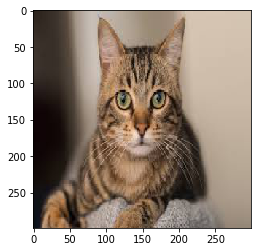

In [28]:
data = run_model('pics/cat.jpg', inception_v4)

In [29]:
show_results(data)

index	prob	label
******************************
281	80.23%	tabby, tabby cat
285	8.13%	Egyptian cat
282	5.64%	tiger cat
287	0.10%	lynx, catamount
283	0.05%	Persian cat
